# Final Submission
*Strategy: Regressor the PCIAT-PCIAT_Total Feature*

## 1. Import neccessary libraries

In [1]:
import numpy as np, pandas as pd, os
from sklearn.model_selection import cross_val_score, StratifiedKFold
import xgboost as xgb
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import make_scorer, cohen_kappa_score
import os
import re
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor
import warnings
warnings.simplefilter('ignore')

## 2. Reading data

In our previous approach, we thought that one possible reason the public score did not meet our expectations was that we did not utilize the actigraphy files so in this approach, we use both the CSV files and the actigraphy files.

### Read the csv file

In [2]:
df_train = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/train.csv', index_col='id')
df_test = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/test.csv', index_col='id')

### Helper function to load time series file

To load the actigraphy files we use premade helper functions. This function dropped the ‘step’ column in actigraphy files  .

In [3]:
def process_file(filename, dirname):
    df = pd.read_parquet(os.path.join(dirname, filename, 'part-0.parquet'))
    df.drop('step', axis=1, inplace=True)
    return df.describe().values.reshape(-1), filename.split('=')[1]

def load_time_series(dirname) -> pd.DataFrame:
    ids = os.listdir(dirname)
    with ThreadPoolExecutor() as executor:
        results = list(tqdm(executor.map(lambda fname: process_file(fname, dirname), ids), total=len(ids)))
    stats, indexes = zip(*results)
    df = pd.DataFrame(stats, columns=[f"Stat_{i}" for i in range(len(stats[0]))])
    df['Index'] = indexes
    df = df.set_index('Index')
    return df

### Read time series file

In [4]:
train_ts = load_time_series("/kaggle/input/child-mind-institute-problematic-internet-use/series_train.parquet")
test_ts = load_time_series("/kaggle/input/child-mind-institute-problematic-internet-use/series_test.parquet")

100%|██████████| 2/2 [00:00<00:00,  9.46it/s]


Then we combine the csv features with actigraphy features, which we have total 177 features in train set and 154 in test set.

### Concat the dataframes

In [5]:
df_train = df_train.join(train_ts, how="left")
df_test = df_test.join(test_ts, how="left")

In [6]:
df_train.shape

(3960, 177)

In [7]:
df_test.shape

(20, 154)

The test set has less features than the training data

## 3. Data Cleaning

### Remove samples that lack an output label.

In [8]:
df_train.dropna(subset='sii', inplace=True)

### List the missing columns

In [9]:
missing_columns = (set(df_train.columns) - set(df_test.columns)) - {'sii'}
missing_columns

{'PCIAT-PCIAT_01',
 'PCIAT-PCIAT_02',
 'PCIAT-PCIAT_03',
 'PCIAT-PCIAT_04',
 'PCIAT-PCIAT_05',
 'PCIAT-PCIAT_06',
 'PCIAT-PCIAT_07',
 'PCIAT-PCIAT_08',
 'PCIAT-PCIAT_09',
 'PCIAT-PCIAT_10',
 'PCIAT-PCIAT_11',
 'PCIAT-PCIAT_12',
 'PCIAT-PCIAT_13',
 'PCIAT-PCIAT_14',
 'PCIAT-PCIAT_15',
 'PCIAT-PCIAT_16',
 'PCIAT-PCIAT_17',
 'PCIAT-PCIAT_18',
 'PCIAT-PCIAT_19',
 'PCIAT-PCIAT_20',
 'PCIAT-PCIAT_Total',
 'PCIAT-Season'}

Text(0.5, 1.0, 'Count of sii')

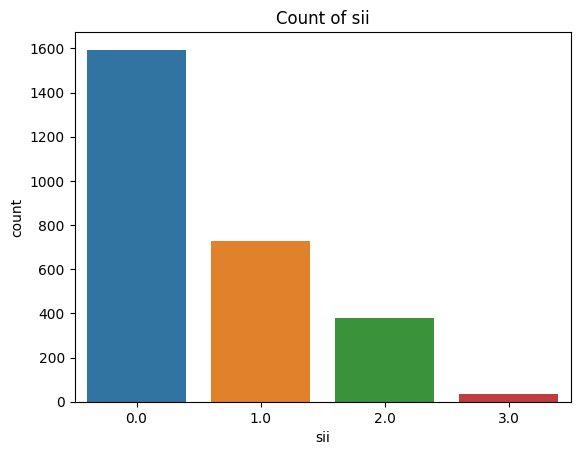

In [10]:
sns.countplot(df_train, x = 'sii').set_title('Count of sii')

In [11]:
value_counts = df_train['sii'].value_counts()
print(value_counts)

sii
0.0    1594
1.0     730
2.0     378
3.0      34
Name: count, dtype: int64


In [12]:
bins = [-1, 30, 49, 79, float('inf')]
labels = ['0-30', '31-49', '50-79', '>=80']

pciat = df_train['PCIAT-PCIAT_Total']
pciat['range'] = pd.cut(df_train['PCIAT-PCIAT_Total'], bins=bins, labels=labels, right=True)
value_pciat_counts = pciat['range'].value_counts().sort_index()

print(value_pciat_counts)


PCIAT-PCIAT_Total
0-30     1594
31-49     730
50-79     378
>=80       34
Name: count, dtype: int64


The distribution of samples across each range closely mirrors that of the `sii` values, prompting an examination of their correlation.

In [13]:
correlation = df_train['sii'].corr(df_train['PCIAT-PCIAT_Total'])
correlation

0.899681248425973

**They have the strong positive correlation and almost reach the perfect threshold  
So, instead of predicting directly the `sii` label we will predict the `PCIAT-PCIAT_Total` feature and create a mapping function to map the results after predicting**

### Convert from PCIAT-PCIAT_Total to sii

In [24]:
def convert(scores):
    scores = np.array(scores) * 1.252
    res = np.zeros_like(scores)
    res[scores <= 30] = 0
    res[(scores > 30) & (scores < 50)] = 1
    res[(scores >= 50) & (scores < 80)] = 2
    res[scores >= 80] = 3
    return res

### Drop missing columns, only keep PCIAT_PCIAT-Total to predict

In [14]:
missing_columns.remove('PCIAT-PCIAT_Total')
df_train.drop(missing_columns, axis=1, inplace=True)

## 4. Feature Engineering

### Feature Encoding

Next, we use label encoder to handle with  categorical features

- Feature encoding: Regarding the categorical feature with a `dtype=object` (the Season feature), we handle it by filling the missing cells with `0` and mapping the season names to numerical values: Spring as `1`, Summer as `2`, Fall as `3`, and Winter as `4`.

In [15]:
categorical_cols = df_train.select_dtypes(include=['object', 'category']).columns.tolist()

season_map = {'Spring': 1, 'Summer': 2, 'Fall': 3, 'Winter': 4}

for col in categorical_cols:
    df_train[col] = df_train[col].fillna(0)
    df_train[col] = df_train[col].map(season_map).fillna(df_train[col])
    
    df_test[col] = df_test[col].fillna(0)
    df_test[col] = df_test[col].map(season_map).fillna(df_test[col])


Now the training data becomes

In [16]:
df_train

,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,...,Stat_86,Stat_87,Stat_88,Stat_89,Stat_90,Stat_91,Stat_92,Stat_93,Stat_94,Stat_95
id,,,,,,,,,,,,,,,,,,,,,
00008ff9,3,5,0,4.0,51.0,3.0,16.877316,46.0,50.8,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
000fd460,2,9,0,0.0,NaN,3.0,14.035590,48.0,46.0,22.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00105258,2,10,1,3.0,71.0,3.0,16.648696,56.5,75.6,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00115b9f,4,9,0,3.0,71.0,2.0,18.292347,56.0,81.6,NaN,...,1.546979,4.004276,89.751656,0.0,2633.250000,4188.5,8.611000e+13,7.0,3.0,85.0
001f3379,1,13,1,4.0,50.0,2.0,22.279952,59.5,112.2,NaN,...,1.146284,2.952888,89.476036,1.0,2597.800049,4175.0,8.639500e+13,7.0,3.0,91.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ff6c2bb8,3,8,0,0.0,NaN,3.0,17.139810,52.5,67.2,25.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ff759544,2,7,1,0.0,NaN,2.0,13.927006,48.5,46.6,23.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ff8a2de4,3,13,0,1.0,60.0,3.0,16.362460,59.5,82.4,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Feature Extraction

### Check correlation between each feature and PCIAT-PCIAT_Total

After that, we use feature extraction to remove the unefficient features

- We check the correlation between each feature and PCIAT_PCIAT-Total and only keep the most importances feature (correlation >0.05 or -0.05)

In [17]:
corr = pd.DataFrame(df_train.corr()['PCIAT-PCIAT_Total'].sort_values(ascending = False))
corr.style.background_gradient(cmap='coolwarm')

,PCIAT-PCIAT_Total
PCIAT-PCIAT_Total,1.000000
sii,0.899681
Physical-Height,0.420765
Basic_Demos-Age,0.409559
PreInt_EduHx-computerinternet_hoursday,0.374124
Physical-Weight,0.353048
Physical-Waist_Circumference,0.327013
FGC-FGC_CU,0.287494
BIA-BIA_BMI,0.248060
Physical-BMI,0.240858


### Keep the most importance features

In [18]:
selected = corr[(corr['PCIAT-PCIAT_Total']>.05) | (corr['PCIAT-PCIAT_Total']<-.05)]
selected = [col for col in selected.index]
selected.remove('PCIAT-PCIAT_Total')
selected.remove('sii')

### Check the missing values per feature

We also drop features which miss more than a half like previous approach

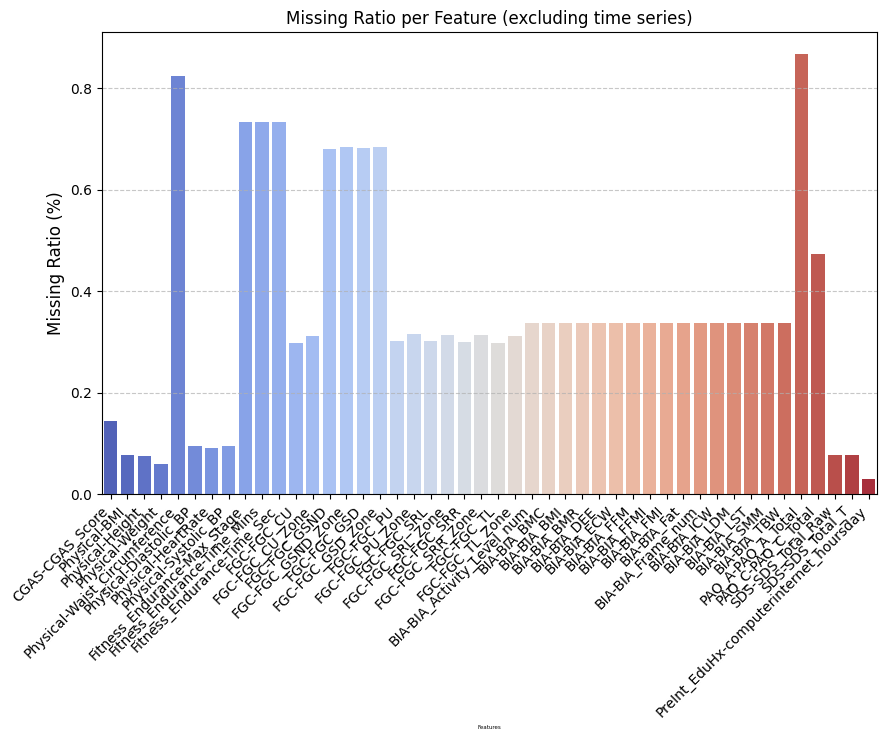

In [19]:
missing_ratio = df_train.isna().mean()

missing_ratio = missing_ratio[missing_ratio > 0]
missing_ratio = missing_ratio[~missing_ratio.index.str.contains('Stat')]

missing_df = missing_ratio.reset_index()
missing_df.columns = ['Feature', 'Missing Ratio']

plt.figure(figsize=(10, 6))
sns.barplot(data=missing_df, x='Feature', y='Missing Ratio', palette='coolwarm')
plt.title('Missing Ratio per Feature (excluding time series)', fontsize=12)
plt.ylabel('Missing Ratio (%)', fontsize=12)
plt.xlabel('Features', fontsize=4)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


### Remove features which misses more than 1/2 excluding time series features

In [20]:
missing_half = [col for col in df_train.columns[df_train.isnull().sum()>len(df_train) / 2] if 'Stat' not in col]
missing_half

['Physical-Waist_Circumference',
 'Fitness_Endurance-Max_Stage',
 'Fitness_Endurance-Time_Mins',
 'Fitness_Endurance-Time_Sec',
 'FGC-FGC_GSND',
 'FGC-FGC_GSND_Zone',
 'FGC-FGC_GSD',
 'FGC-FGC_GSD_Zone',
 'PAQ_A-PAQ_A_Total']

In [21]:
selected = [i for i in selected if i not in missing_half]
selected

['Physical-Height',
 'Basic_Demos-Age',
 'PreInt_EduHx-computerinternet_hoursday',
 'Physical-Weight',
 'FGC-FGC_CU',
 'BIA-BIA_BMI',
 'Physical-BMI',
 'SDS-SDS_Total_T',
 'SDS-SDS_Total_Raw',
 'PAQ_A-Season',
 'FGC-FGC_PU',
 'BIA-BIA_Frame_num',
 'Physical-Systolic_BP',
 'FGC-FGC_TL',
 'Stat_37',
 'Stat_80',
 'Stat_17',
 'PAQ_C-Season',
 'Stat_32',
 'BIA-BIA_FFMI',
 'Stat_77',
 'Stat_29',
 'Stat_36',
 'Stat_65',
 'BIA-BIA_FMI',
 'Stat_89',
 'Stat_53',
 'Stat_28',
 'BIA-BIA_Activity_Level_num',
 'BIA-BIA_LST',
 'Stat_26',
 'Physical-Diastolic_BP',
 'Stat_57',
 'Stat_48',
 'FGC-FGC_PU_Zone',
 'BIA-BIA_DEE',
 'BIA-BIA_SMM',
 'BIA-BIA_ICW',
 'Stat_46',
 'Stat_94',
 'Stat_70',
 'Stat_47',
 'Stat_22',
 'Stat_59',
 'Stat_23',
 'Stat_83',
 'Stat_71',
 'Stat_95',
 'Stat_82',
 'Stat_90',
 'CGAS-CGAS_Score',
 'FGC-FGC_SRR',
 'Stat_18',
 'Stat_72',
 'FGC-FGC_SRL',
 'Stat_86',
 'Basic_Demos-Sex',
 'Fitness_Endurance-Season',
 'Stat_84',
 'Stat_51',
 'FGC-FGC_SRR_Zone',
 'Stat_30',
 'Stat_24',
 'St

## 5. Training model

We select the XGBoost Regressor to train the model. XGBoost (Extreme Gradient Boosting) is a powerful and efficient machine learning algorithm designed for structured data. It is an implementation of gradient-boosted decision trees, optimized for speed and performance.

XGBoost operates by sequentially building decision trees, where each new tree attempts to correct the errors of the previous ones. It combines these trees to make predictions, improving accuracy over time. The algorithm uses gradient descent to minimize the loss function and includes regularization techniques to prevent overfitting.

One key advantage of XGBoost is its ability to handle missing values automatically by learning the best direction to take in a decision tree when encountering them. This eliminates the need for explicit imputation, making it a robust choice for datasets with incomplete information. Additionally, XGBoost supports parallel processing, which significantly speeds up training on large datasets.

### Extract the data frame

In [22]:
X = df_train[selected]
y = df_train['PCIAT-PCIAT_Total']
df_test = df_test[selected]

In [23]:
X

,Physical-Height,Basic_Demos-Age,PreInt_EduHx-computerinternet_hoursday,Physical-Weight,FGC-FGC_CU,BIA-BIA_BMI,Physical-BMI,SDS-SDS_Total_T,SDS-SDS_Total_Raw,PAQ_A-Season,...,FGC-FGC_SRR_Zone,Stat_30,Stat_24,Stat_85,Stat_87,FGC-FGC_SRL_Zone,Stat_63,Stat_75,Stat_27,Stat_15
id,,,,,,,,,,,,,,,,,,,,,
00008ff9,46.0,5,3.0,50.8,0.0,16.8792,16.877316,NaN,NaN,0.0,...,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
000fd460,48.0,9,0.0,46.0,3.0,14.0371,14.035590,64.0,46.0,0.0,...,1.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
00105258,56.5,10,2.0,75.6,20.0,NaN,16.648696,54.0,38.0,0.0,...,1.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
00115b9f,56.0,9,0.0,81.6,18.0,18.2943,18.292347,45.0,31.0,0.0,...,0.0,208.168976,0.453665,1.666354,4.004276,0.0,0.023637,0.041420,0.106351,0.047388
001f3379,59.5,13,0.0,112.2,12.0,30.1865,22.279952,56.0,40.0,0.0,...,1.0,95.327438,0.351545,1.946303,2.952888,1.0,0.009831,0.010668,0.024331,0.011926
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ff6c2bb8,52.5,8,2.0,67.2,0.0,17.1417,17.139810,58.0,41.0,0.0,...,1.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
ff759544,48.5,7,0.0,46.6,0.0,13.6457,13.927006,67.0,48.0,0.0,...,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
ff8a2de4,59.5,13,1.0,82.4,16.0,16.3642,16.362460,50.0,35.0,0.0,...,1.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN


For the splitting strategy, we use `StratifiedKFold` from `sklearn` with `n_splits=5`, which is more efficient than `train_test_split`  and the evaluation metric is still qwk because we have converted the PCIAT-PCIAT_Total to the sii format

### The evaluation metric

In [25]:
def quadratic_weight_kappa(y_true, y_pred):
    y_true_sii = convert(y_true)
    y_pred_sii = convert(y_pred)
    return cohen_kappa_score(y_true_sii, y_pred_sii, weights='quadratic')

qwk_scorer = make_scorer(quadratic_weight_kappa, greater_is_better=True)

### The split strategy

In [26]:
skf = StratifiedKFold(n_splits=5)

### Optimization strategy

The optimization method we chose is Bayesian Optimization, which is well-suited for finding the best hyperparameters within a defined range, unlike GridSearchCV, which searches over a predefined set of values. The hyperparameters ranges were selected based on insights gained from our previous submissions.

In [27]:
from bayes_opt import BayesianOptimization
import xgboost as xgb
from sklearn.model_selection import cross_val_score

def objective_function(n_estimators, learning_rate, subsample, colsample_bytree, max_depth):
    params = {
        'n_estimators': int(n_estimators),
        'learning_rate': learning_rate,
        'subsample': subsample,
        'colsample_bytree': colsample_bytree,
        'max_depth': int(max_depth),
        'random_state': 42
    }
    model = xgb.XGBRegressor(**params)
    scores = cross_val_score(model, X, y, cv=skf, scoring=qwk_scorer, n_jobs=-1)
    return scores.mean()

param_bounds = {
    'max_depth': (3,6),
    'n_estimators': (50, 300),
    'learning_rate': (0.01, 0.1),
    'subsample': (0.5, 1.0),
    'colsample_bytree': (0.5, 1.0),
}

optimizer = BayesianOptimization(
    f=objective_function,
    pbounds=param_bounds,
    random_state=42
)

optimizer.maximize(init_points=10, n_iter=90)

print("Best parameters:", optimizer.max)


|   iter    |  target   | colsam... | learni... | max_depth | n_esti... | subsample |
-------------------------------------------------------------------------------------
| 1         | 0.4024    | 0.6873    | 0.09556   | 5.196     | 199.7     | 0.578     |
| 2         | 0.4406    | 0.578     | 0.01523   | 5.599     | 200.3     | 0.854     |
| 3         | 0.4249    | 0.5103    | 0.09729   | 5.497     | 103.1     | 0.5909    |
| 4         | 0.4612    | 0.5917    | 0.03738   | 4.574     | 158.0     | 0.6456    |
| 5         | 0.443     | 0.8059    | 0.02255   | 3.876     | 141.6     | 0.728     |
| 6         | 0.4593    | 0.8926    | 0.02797   | 4.543     | 198.1     | 0.5232    |
| 7         | 0.4592    | 0.8038    | 0.02535   | 3.195     | 287.2     | 0.9828    |
| 8         | 0.4595    | 0.9042    | 0.03742   | 3.293     | 221.1     | 0.7201    |
| 9         | 0.4482    | 0.561     | 0.05457   | 3.103     | 277.3     | 0.6294    |
| 10        | 0.4485    | 0.8313    | 0.03805   | 4.56

 After run over 100 iterations we got the best params corresponding to the best score.  We assigned it to the model and train the model

### The model's params

In [28]:
xgb_params = {
    'max_depth': 4,
    'n_estimators': 157,
    'learning_rate': 0.04007738100469222,
    'subsample': 0.5432400998472477,
    'colsample_bytree': 0.8214112330652663,
    'random_state': 42,
}

model = xgb.XGBRegressor(**xgb_params)

### Train the model

In [29]:
model.fit(X,y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8214112330652663, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.04007738100469222, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=157, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

## 6. Evaluate model

In [30]:
scores = cross_val_score(model, X, y, cv=skf, scoring=qwk_scorer)
print("QWK Scores:", scores)
print("----> Mean QWK Score:", np.mean(scores))

QWK Scores: [0.42507361 0.52498236 0.44261374 0.50300074 0.43963159]
----> Mean QWK Score: 0.46706040837853724


We get evaluation score at 0.467 - very good score so we choose to use this model to make the final predictions

## 7. Submit to competition

### Convert from PCIAT-PCIAT_Total to sii format

In [34]:
preds = model.predict(df_test)
preds = convert(preds)
preds = np.array(preds).astype(int)

### Write the predictions to submission file

In [35]:
output = pd.DataFrame({'id': df_test.index,
                       'sii': preds})
output.to_csv('submission.csv',index=False)
output

,id,sii
0,00008ff9,1
1,000fd460,0
2,00105258,1
3,00115b9f,0
4,0016bb22,1
5,001f3379,1
6,0038ba98,0
7,0068a485,0
8,0069fbed,1
9,0083e397,1
